# About

This notebook aim for trying the mpsk demo code on simple dataset and learn how the code works

# Set environment

In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs
%load_ext rpy2.ipython
%matplotlib inline

In [2]:
plt.style.use('seaborn-darkgrid')

In [58]:
%%R 
library("tidyverse")
library("MPSK")
library("RColorBrewer")

# Simulate data

Set parameters

In [11]:
delta1 = np.array([0.5, 0.5])
delta2 = np.array([-0.5, 0.5])
delta3 = np.array([0.5, -0.5])

n1 = 100
n4 = 100
n2 = 850
n5 = 850
n3 = 50
n6 = 50

m1 = np.array([0,0])
m4 = m1 + delta1
m2 = np.array([3,3])
m5 = m2 + delta2
m3 = np.array([0,3])
m6 = m3 + delta3

s1 = np.eye(2)
s4 = np.eye(2)
s2 = np.eye(2)
s5 = np.eye(2)
s3 = np.eye(2)
s6 = np.eye(2)

In [12]:
### set seed
np.random.seed(123)

### generate sample 01; contain three clusters
U1 = np.random.multivariate_normal(m1, s1, n1)
U2 = np.random.multivariate_normal(m2, s2, n2)
U3 = np.random.multivariate_normal(m3, s3, n3)
Y1 = np.concatenate([U1, U2, U3])
Z1 = np.concatenate([[1]*n1, [2]*n2, [3]*n3])
C1 = 1 * np.ones(n1+n2+n3)

### generate sample 02; contain three clusters
V1 = np.random.multivariate_normal(m4, s4, n4)
V2 = np.random.multivariate_normal(m5, s5, n5)
V3 = np.random.multivariate_normal(m6, s6, n6)
Y2 = np.concatenate([V1, V2, V3])
Z2 = np.concatenate([[1]*n4, [2]*n5, [3]*n6])
C2 = 2 * np.ones(n4+n5+n6)

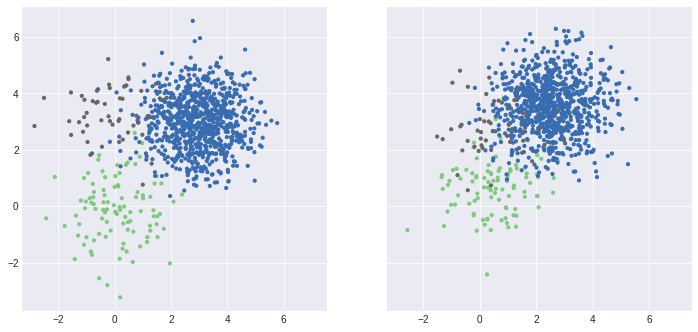

In [60]:
### set plot
fig, axes = plt.subplots(1, 2, figsize = (12, 6), sharex = True, sharey = True)
s = 10

### plot sample 01
axes[0].scatter(Y1[:, 0], Y1[:, 1], c = Z1, s = s, cmap = plt.cm.Accent)
axes[0].axis('square')

### plot sample 02
axes[1].scatter(Y2[:, 0], Y2[:, 1], c = Z2, s = s, cmap = plt.cm.Accent)
axes[1].axis('square')
pass

# Arrange data

row bind the data (Y) and label (C)

In [27]:
Y = np.concatenate([Y1, Y2])
C = np.concatenate([C1,C2]).astype('int')

check the shape of data

In [28]:
Y.shape, C.shape

((2000, 2), (2000,))

send to R environment

In [39]:
%%R -i Y,C
cat("", "Y:", dim(Y), "\n", "C:", dim(C))

 Y: 2000 2 
 C: 2000

# Apply MPSK model

Apply MPSK model, relabeling, calibration, and summarize MCMC

In [40]:
%%R
resMPSK       = mpsk(Y, C)
resRelab      = relabelChain(resMPSK)
resCalibrated = calibrate(resRelab)
chainSummary  = summarizeChain(resRelab)

get / set plot parameters

In [128]:
%%R
J = length(unique(C))            # number of samples
par(mfrow = c(3, J))             # 
par(mar=c(2.5, 2.5, 1.5, 0))     # set margin
kIdx = unique(chainSummary$t)    # not sure what t is; my guess: cluster index (b/c k idx)

Notes

In [99]:
%%R
print(J)
print(kIdx) # not empty cluster from the ten cluster define by dirichlet process
print(length(chainSummary$t))

[1] 2
[1] 1 4 3
[1] 2000


# Visualize the results

helper function

In [116]:
%%R
my_set_style <- function(){
    plot(0, 0, type = "n", ann = FALSE, axes = FALSE)          # empty plot
    u <- par("usr")                                            # The coordinates of the plot area
    rect(u[1], u[3], u[2], u[4], col = "#EAEAF2", border = NA) # set plot background (seaborn: #EAEAF2)
    #rect(u[1], u[3], u[2], u[4], col = "#dcdcf2", border = NA) 
    grid(lty = 1, lwd = 2, col = "white")                      # grid line
    par(new=TRUE)
}

### Plot and color the <font color = 'blue'>original</font> data:

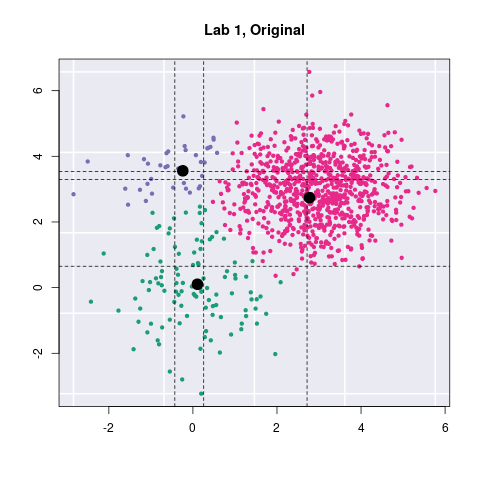

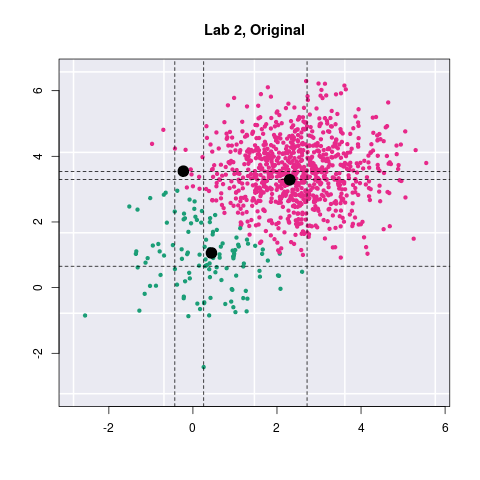

In [129]:
%%R
# Plot and color the original data:
res <- resMPSK

for (j in 1:J) { # for each sample
    
    ### set style
    my_set_style()
    
    # range of x and y coordinate
    xrng = range(Y[,1])
    yrng = range(Y[,2])
    
    # plot each cluster
    plot(
        ### coordinate
        res$data$Y[C == j, 1], res$data$Y[C == j, 2], 
        
        ### markers
        pch = 20, cex = 1, #pch="'", cex = 3,
        col = brewer.pal(res$prior$K, "Dark2")[chainSummary$t[C == j]],
        #col=rainbow(res$prior$K)[chainSummary$t[C==j]],
        
        ### labels
        main = paste0("Lab ", j, ", Original"),
        xlab = "",   ylab = "", 
        xlim = xrng, ylim = yrng)
    
    ### meanvec
    abline(h = chainSummary$meanvec0[2, kIdx], lty = 2)
    abline(v = chainSummary$meanvec0[1, kIdx], lty = 2)
    
    ### centers
    points(chainSummary$xi[j, 1, kIdx], chainSummary$xi[j, 2, kIdx], pch = 20, cex = 3)
}

### Plot and color the <font color = 'red'>calibrated</font> data:

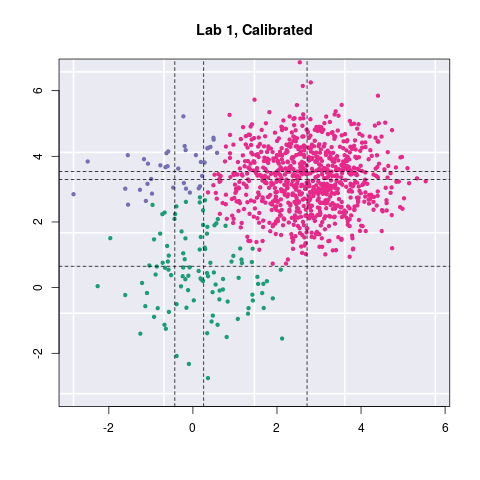

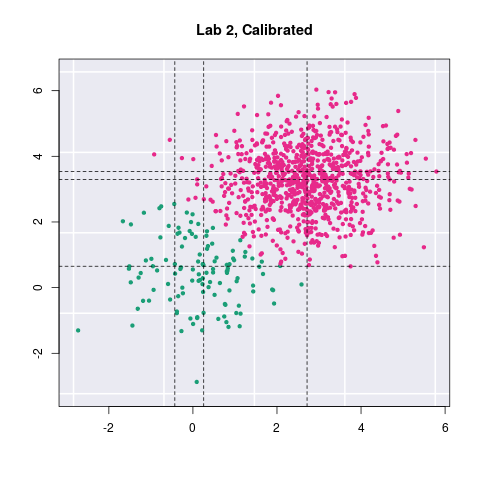

In [118]:
%%R
# Plot and color the calibrated data:
for (j in 1:J) {
    
    ### set style
    my_set_style()
    
    ### plot data
    plot(
        ### coordinate
        resCalibrated$Y_cal[C == j, 1], resCalibrated$Y_cal[C == j, 2], 
        
        ### marker
        pch = 20, cex = 1, #pch="'", 
        col = brewer.pal(res$prior$K, "Dark2")[chainSummary$t[C == j]],
        #col=rainbow(res$prior$K)[chainSummary$t[C==j]],
       
        ### label
        main = paste0("Lab ",j,", Calibrated"),
        xlab="", ylab="", xlim=xrng, ylim=yrng)
    
    ### mean of each cluster across the samples / labs
    abline(h=chainSummary$meanvec0[2, kIdx], lty = 2)
    abline(v=chainSummary$meanvec0[1, kIdx], lty = 2)
}

My observation:  
in the second plot, the pink is shifted rightward.

# Predict / Simulation

Simulating data from the fitted MPSK model

**Note: `sn::dmsn` Multivariate skew-normal distribution** from [package sn](https://cran.r-project.org/web/packages/sn/sn.pdf)

*Probability density function, distribution function and random number generation for the multivariate skew-normal (SN) distribution.*

```
dmsn(x, xi=rep(0,length(alpha)), Omega, alpha, tau=0, dp=NULL, log=FALSE)
pmsn(x, xi=rep(0,length(alpha)), Omega, alpha, tau=0, dp=NULL, ...)
rmsn(n=1, xi=rep(0,length(alpha)), Omega, alpha, tau=0, dp=NULL)
```



In [119]:
%%R

### initialization
genY = NULL # data
genC = NULL # label --- sample / lab
genT = NULL # label --- cluster w/in a sample

### k --- cluster ; j --- sample / lab
for (k in 1:length(kIdx)) { # for each cluster
    
    ### acquire the corresponding cluster idx from the fitted data
    kk = kIdx[k]
    
    for (j in 1:J) { # for each sample
        
        ### proportion / weight of a cluster
        njk = floor(sum(C == j) * chainSummary$W[j, kk])
        
        ### generate a cluster from skew normal
        genY = rbind(genY, 
        
                     ### skew normal distribution
                     sn::rmsn(n     = njk, 
                              xi    = chainSummary$xi[j,,kk],
                              Omega = chainSummary$Omega[,,kk],
                              alpha = chainSummary$alpha[,kk]))
        
        ### label of sample / lab
        genC = c(genC, rep(j, njk))
        
        ### label of cluster
        genT = c(genT, rep(kk, njk))
  }
}

Visualize the simulation

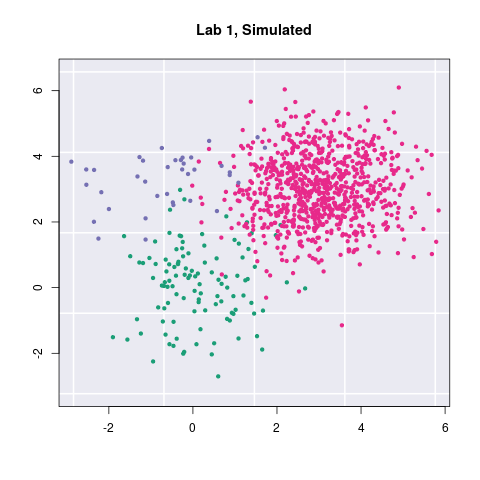

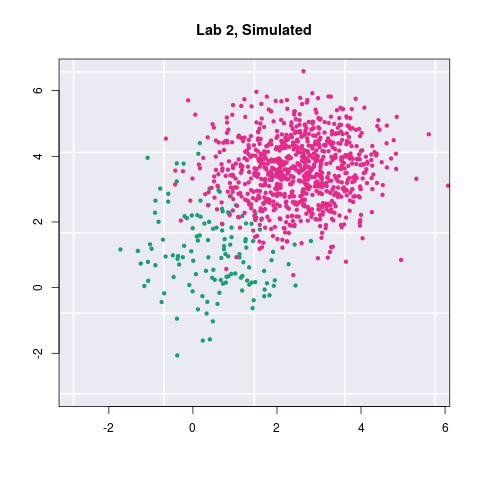

In [120]:
%%R
for (j in 1:J) { # for each sample / lab
    
    ### set style
    my_set_style()
    
    ### plot data
    plot(
        ### coord
        genY[genC == j, 1],
        genY[genC == j, 2], 
        
        ### marker
        pch = 20, cex = 1, # pch="'", 
        col = brewer.pal(res$prior$K, "Dark2")[genT[genC == j]],
        #col = rainbow(res$prior$K)[genT[genC==j]],
                    
        ### label
        main = paste0("Lab ",j,", Simulated"),
        xlab = "",   ylab = "", 
        xlim = xrng, ylim = yrng, 
    ) # end plot
    
} # end for loop

# Appendix

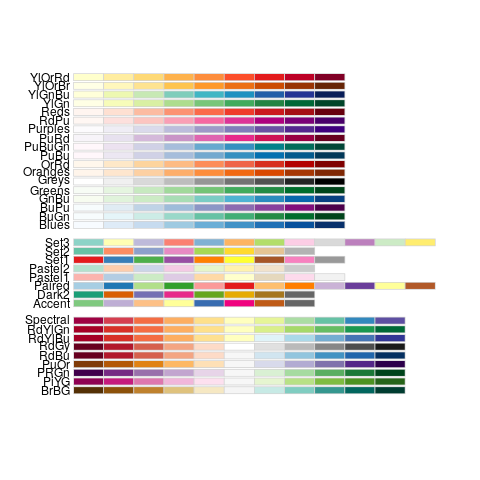

In [121]:
%%R
display.brewer.all()